In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib
plt.rcParams['axes.grid'] = True
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10,6)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# dataframe info
def info(df, first=5, c=1):
    if c: print(list(df.columns))
    print('DF Shape: ',df.shape)
    return df.head(first)

In [3]:
data = pd.read_csv('AirPassengers.csv')

In [4]:
info(data)

['Month', '#Passengers']
DF Shape:  (144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
# convert date into pandas DateTime format, rename columns
data['Month'] = pd.to_datetime(data['Month'])
df = data.rename(columns={'#Passengers':'Count'})
info(df)

['Month', 'Count']
DF Shape:  (144, 2)


,Month,Count
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
# set date as index
df.set_index(df['Month'], drop=True, inplace=True)
df.drop('Month', axis=1, inplace=True)
info(df)

['Count']
DF Shape:  (144, 1)


,Count
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

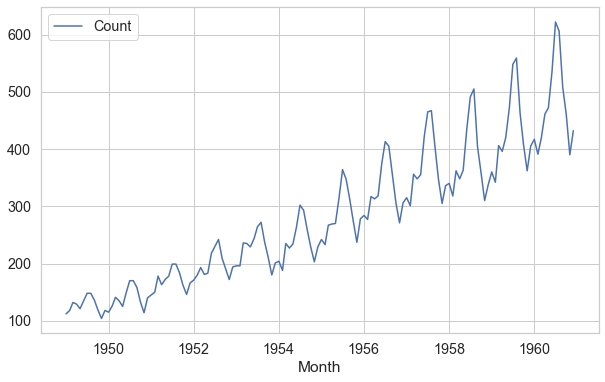

In [7]:
sns.lineplot(data=df)

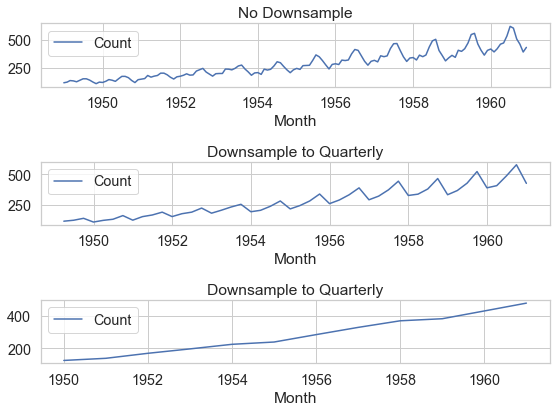

In [14]:
# downsampled plots
fig, ax = plt.subplots(3,1, layout='tight', figsize=(8,6))

sns.lineplot(ax=ax[0], data = df).set(title='No Downsample')
sns.lineplot(ax=ax[1], data=df.resample('Q').mean()).set(title='Downsample to Quarterly')
sns.lineplot(ax=ax[2], data=df.resample('Y').mean()).set(title='Downsample to Quarterly')
plt.show()

In [15]:
# Stationarity Test
def st_test(df, col='Count'):
    # for plotting
    moving_avg = df.rolling(window=12).mean()
    moving_std = df.rolling(window=12).std()
    
    fig, ax = plt.subplots(1,1)
    sns.lineplot(x=df.index, y=col, data=df, color='silver', label='Original Data')
    sns.lineplot(x=df.index, y=col, data=moving_avg, color='blue', label='Rolling MEAN')
    sns.lineplot(x=df.index, y=col, data=moving_std, color='red', label='Rolling STD')
    ax.set_title('Stationary Test')
    plt.show()
    
    # Dickey Fuller test
    print('Dickey Fuller Test:')
    dftest = adfuller(df[col], autolag='AIC')
    dft = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dft['Critical Value (%s)'%key] = value
    print(dft)

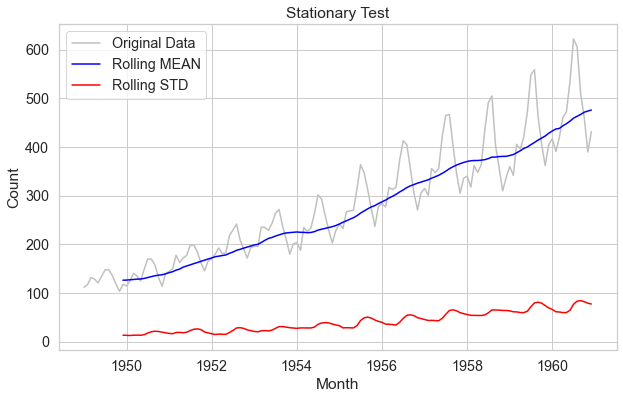

Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
# plot rolling mean and rolling std for current data
st_test(df)

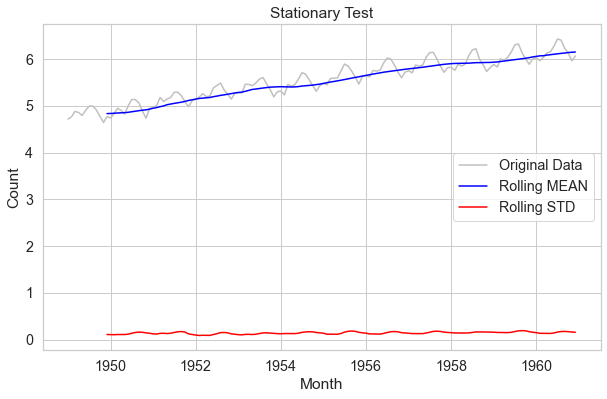

Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
# log trasnformation
df_log = np.log(df)
st_test(df_log)

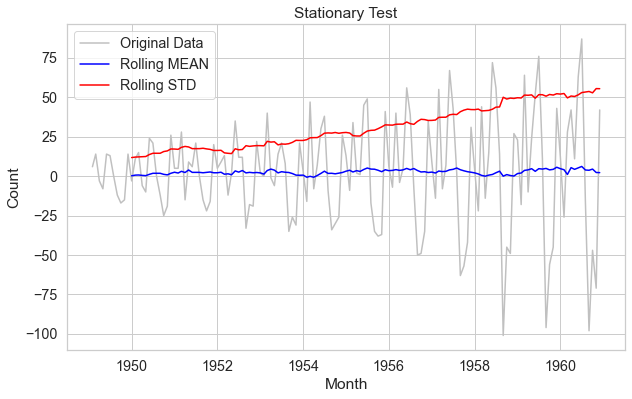

Dickey Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
df_diff = df.diff()
df_diff.dropna(inplace=True)
st_test(df_diff)

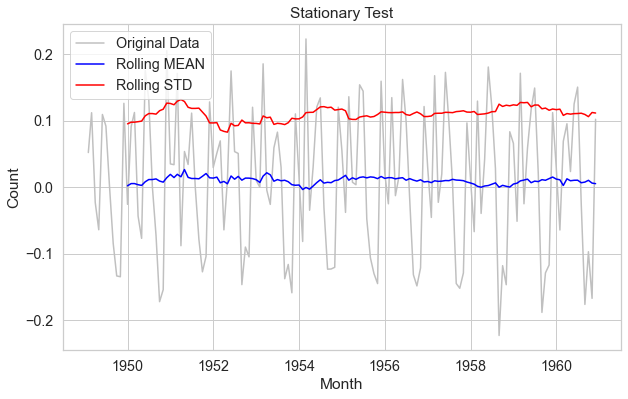

Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [21]:
df_log_diff = df_log.diff()
df_log_diff.dropna(inplace=True)
st_test(df_log_diff)

In [24]:
model = ARIMA(df['Count'],order = (2,1,2))
model_fit = model.fit()
model_fit.summary()

/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Thu, 12 Jan 2023   AIC                           1353.347
Time:                        21:18:07   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.058      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.419      0.000      -0.989      -0.921
ma.L1         -1.8432      0.125    -14.776      0.000      -2.088      -1.599
ma.L2          0.9953      0.135      7.363      0.000       0.730       1.260
sigma2       665.9541    114.206      5.831      0.000     442.115     889.793
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.59   Prob(JB):                         0.40
Heteroskedasticity (H):               7.38   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# calculating moving average which will help in transformation of  non
moving_avg = df_log.rolling(window=12).mean()
moving_std = df_log.rolling(window=12).std()
moving_avg, moving_std

(               Count
 Month               
 1949-01-01       NaN
 1949-02-01       NaN
 1949-03-01       NaN
 1949-04-01       NaN
 1949-05-01       NaN
 ...              ...
 1960-08-01  6.124517
 1960-09-01  6.132246
 1960-10-01  6.142628
 1960-11-01  6.148837
 1960-12-01  6.154215
 
 [144 rows x 1 columns],
                Count
 Month               
 1949-01-01       NaN
 1949-02-01       NaN
 1949-03-01       NaN
 1949-04-01       NaN
 1949-05-01       NaN
 ...              ...
 1960-08-01  0.171453
 1960-09-01  0.174172
 1960-10-01  0.169804
 1960-11-01  0.160923
 1960-12-01  0.156660
 
 [144 rows x 1 columns])

In [13]:
# transformation to make timeseries stationary
df_transformed = df_log - moving_avg
df_transformed[:12]

,Count
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [14]:
# removing null values from the trasnformed data
df_transformed.dropna(inplace=True)
df_transformed[:12]

,Count
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


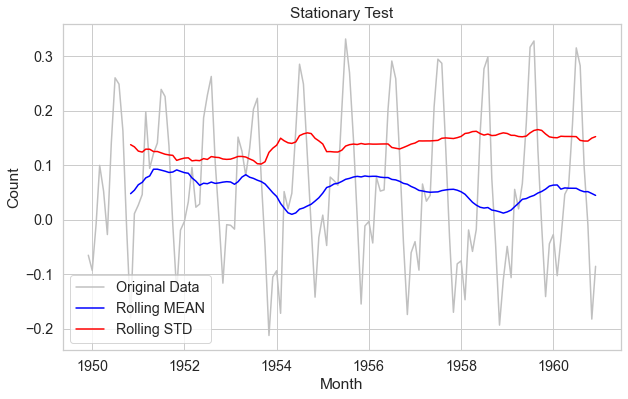

Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [15]:
st_test(df_transformed)

### p-value is very less and close to 0.01 than before, along with this critical values are close to test statistic than before as well hence we can say that the transformed time series is stationary

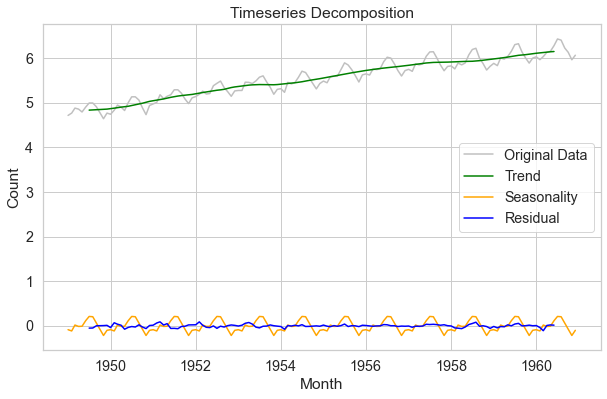

In [16]:
decomposed = seasonal_decompose(df_log)
fig, ax = plt.subplots(1,1)
sns.lineplot(x=df_log.index, y='Count', data=df_log, color='silver', label='Original Data')
sns.lineplot(x=decomposed.trend.index, y=decomposed.trend.values, color='green', label='Trend')
sns.lineplot(x=decomposed.seasonal.index, y=decomposed.seasonal.values, color='orange', label='Seasonality')
sns.lineplot(x=decomposed.resid.index, y=decomposed.resid.values, color='blue', label='Residual')
ax.set_title('Timeseries Decomposition')
plt.show()

In [17]:
residual = decomposed.resid
residual

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: resid, Length: 144, dtype: float64

In [18]:
residual.dropna(inplace=True)
residual

Month
1949-07-01   -0.050884
1949-08-01   -0.048415
1949-09-01    0.001223
1949-10-01    0.003156
1949-11-01    0.005749
                ...   
1960-02-01   -0.038032
1960-03-01   -0.108624
1960-04-01    0.009006
1960-05-01    0.020213
1960-06-01    0.015348
Name: resid, Length: 132, dtype: float64

In [19]:
residual = pd.DataFrame(residual)
residual

,resid
Month,
1949-07-01,-0.050884
1949-08-01,-0.048415
1949-09-01,0.001223
1949-10-01,0.003156
1949-11-01,0.005749
...,...
1960-02-01,-0.038032
1960-03-01,-0.108624
1960-04-01,0.009006


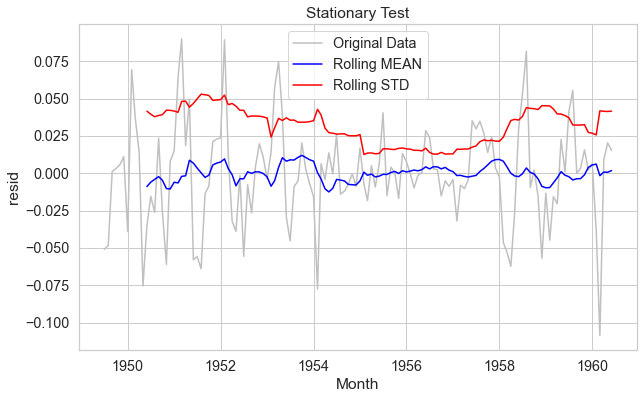

Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [20]:
st_test(residual, col='resid')

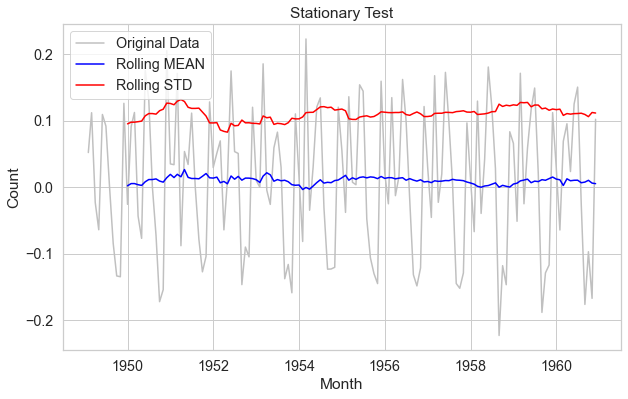

Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [21]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
st_test(df_log_shift)

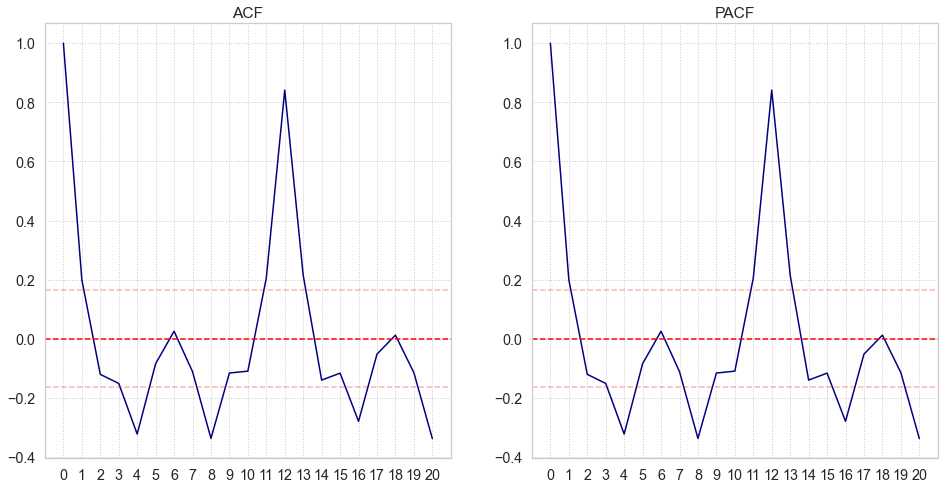

In [24]:
# auto correlation and partial-auto correlation plots

acf = acf(df_log_shift, nlags=20)
pacf = pacf(df_log_shift, nlags=20, method='ols')

# ACF and PACF plots

# Auto Correlation Function
xticks = range(len(acf))
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.lineplot(y=acf,x= xticks, ax=ax[0], color='navy')
ax[0].axhline(0, ls='--', color='red')
ax[0].axhline(-1.96/np.sqrt(len(df_log_shift)), ls='--', color='red', alpha=0.3)
ax[0].axhline(1.96/np.sqrt(len(df_log_shift)), ls='--', color='red', alpha=0.3)
ax[0].set_xticks(xticks)
ax[0].grid(ls=':')
ax[0].set_title('ACF')

#Partial Auto Correlation Function
xticks = range(len(pacf))
sns.lineplot(y=acf,x= xticks, ax=ax[1], color='navy')
ax[1].axhline(0, ls='--', color='red')
ax[1].axhline(-1.96/np.sqrt(len(df_log_shift)), ls='--', color='red', alpha=0.3)
ax[1].axhline(1.96/np.sqrt(len(df_log_shift)), ls='--', color='red', alpha=0.3)
ax[1].set_xticks(xticks)
ax[1].grid(ls=':')
ax[1].set_title('PACF')
plt.show()

_From the acf plot: Q=2 (line first crosses 0 at x=2)_<br>
_From the pacf plot: P=2 (line first crosses 0 at x=2)_

>p = order of AR term<br>
>d = order of differencing in-order to make timeseries stationary<br>
>q = order of MA term